$$
\begin{align}
\text{In-Phase Spectral} &= \frac{\sqrt{g^2+2g\cos(\omega\tau_c)+1}}{g^2+2g\cos(\omega\tau_c)+\beta+1} \\
\text{Out-of-Phase Spectral} &= \frac{\sqrt{g^2-2g\cos(\omega\tau_c)+1}}{g^2-2g\cos(\omega\tau_c)+\beta+1} \\
\text{Total Coloration} &= \text{max}(\text{In-Phase Spectral}, \text{Out-of-Phase Spectral}) \\
&= \text{max}(\frac{\sqrt{g^2+2g\cos(\omega\tau_c)+1}}{g^2+2g\cos(\omega\tau_c)+\beta+1},\frac{\sqrt{g^2-2g\cos(\omega\tau_c)+1}}{g^2-2g\cos(\omega\tau_c)+\beta+1}) \\
\text{In-Phase Spectral}_\text{Flatten Peak} &= 1 = \frac{\sqrt{g^2+2g\cos(\omega\tau_c)+1}}{g^2+2g\cos(\omega\tau_c)+\beta+1} \\
\text{Out-of-Phase Spectral}_\text{Flatten Peak} &= 1 = \frac{\sqrt{g^2-2g\cos(\omega\tau_c)+1}}{g^2-2g\cos(\omega\tau_c)+\beta+1}\\
\end{align}
$$

$$
\gamma = 10^{\Gamma / 20}
$$ 
$$
\begin{align}
\beta_\text{In-Phase}(\omega) = \beta_\rm{II}(\omega) &= -g^2 - 2g\cos(\omega\tau_c) +\frac{\sqrt{g^2+2g\cos(\omega\tau_c)+1}}{\gamma} - 1 \\
\beta_\text{Out-of-Phase}(\omega) = \beta_\rm{I}(\omega) &= -g^2 + 2g\cos(\omega\tau_c) +\frac{\sqrt{g^2-2g\cos(\omega\tau_c)+1}}{\gamma} - 1 \\
\end{align}
$$

$$
\begin{align}
z &= e^{i2wt} \\
H^{|B|}_{LL}(z) = H^{|B|}_{RR}(z) &= \frac{z^2g^2-z(B+1)}{z^2g^2+g^2-z[(g^2+B)^2+2B+1]} \\
H^{|B|}_{LR}(z) = H^{|B|}_{RL}(z) &= \frac{z[gz^{-\frac{1}{2}}-g(g^2+B)z^{\frac{1}{2}}]}{z^2g^2+g^2-z[(g^2+B)^2+2B+1]} \\
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from scipy.special import binom
from sympy import binomial

In [2]:
# Parameters
l = 1.6  # L
dr = 0.15  # Distance between ears
theta = (18 / 180) * np.pi  # Half the speaker span
l1 = np.sqrt(l**2 + (dr / 2)**2 - (dr * l * np.sin(theta / 2)))  # L1
l2 = np.sqrt(l**2 + (dr / 2)**2 + (dr * l * np.sin(theta / 2)))  # L2
g = l1 / l2  # g
cs = 340.3  # Speed of sound
dl = abs(l2 - l1)  # Distance difference
tc = dl / cs  # Time delay
tau_s = 3
tau_c = 68e-6  # Time delay for a normal listening room
g = 0.985
fs = 44100
gamma_db = 7

In [3]:
def gamma_db2gain(db):
    return 10 ** (db / 20)

In [4]:
r = gamma_db2gain(gamma_db)

$$
\binom{n}{k} = \frac{n!}{k!(n-k)!}
$$

In [5]:
def delta_function(filter_length, t_shift):
    """Generates a discrete delta function."""
    t_values = np.arange(-filter_length, filter_length + 1)
    delta = np.zeros_like(t_values)
    center_idx = filter_length

    shift_idx = center_idx - t_shift
    if shift_idx < 0 or shift_idx >= len(delta):
        return delta
    
    delta[shift_idx] = 1
    return delta

$$
\psi_0 = -g^2r^2 \delta(t) \pm gr^2 \delta(\tau_c-t) \pm gr^2 \delta(t+\tau_c) -g^2r^2 \delta(t+2\tau_c)
$$

In [6]:
def psi_0(g, r, tau, branch, t):
    pm = 1 if branch == 1 else -1 
    
    comp1 = -g*g*r*r*delta_function(t, 0) 
    comp2 = pm*g*r*r*delta_function(t, -tau) 
    comp3 = pm*g*r*r*delta_function(t,  tau) 
    comp4 = -g*g*r*r*delta_function(t, 2 * tau)

    return comp1 + comp2 + comp3 + comp4

$$
\psi_1 = \sum_{m=0}^{\infty} \binom{1/2}{m} (\mp g)^m (g^2 + 1)^{1/2-m} \times \sum_{k=0}^m \binom{m}{k} \delta(2k\tau_c - t - m\tau_c)
$$

In [7]:
def psi_1(g, tau, branch, t):
    output = np.zeros(t*2+1, dtype=float)

    mp = -1 if branch == 1 else 1  

    for m in range(t):
        comp1 = binom(0.5, m) * (mp * g)**m * (g**2 + 1)**(0.5 - m)

        for k in range(m):
            comp2 = binom(m, k) * delta_function(t, -2 * k * tau + m * tau)
            output += comp1 * comp2

    return output

$$
\psi_2 = \pm \frac{1}{4g\gamma} \sum_{m=0}^{\infty} \binom{-1/2}{m} (-1)^m \times \sum_{k=0}^{2m} \binom{2m}{k} (-1)^{k+m}4^{-m}\delta(t + 2k\tau_c - 2m\tau_c)
$$

In [8]:
def psi_2(g, gamma, tau, branch, t):
    output = np.zeros(t*2+1, dtype=float)
    
    pm = 1 if branch == 1 else -1 

    prefactor = pm / (4 * g * gamma)  
    
    for m in range(t): 
        comp1 = binom(-0.5, m) * (-1)**m
        
        for k in range(2 * m + 1):
            comp2 = binom(2 * m, k) * (-1)**(k + m) * 4**(-m) * delta_function(t, 2 * k * tau - 2 * m * tau)
            output += comp1 * comp2
    
    return prefactor * output

$$
\psi_3 = \sum_{m=0}^{\infty} \binom{-1/2}{m} (\mp g)^m (g^2 + 1)^{1/2-m} \times \sum_{k=0}^m \binom{m}{k} \delta(2k\tau_c - t - m\tau_c)
$$

In [9]:
def psi_3(g, tau, branch, t):
    output = np.zeros(t*2+1, dtype=float)
    
    mp = -1 if branch == 1 else 1  

    for m in range(t):
        comp1 = binom(-0.5, m) * (mp * g)**m * (g**2 + 1)**(0.5 - m)
        
        for k in range(m + 1):
            comp2 = binom(m, k) * delta_function(t, -2 * k * tau + m * tau)
            output += comp1 * comp2 
    
    return output

$$
\psi_4 = 2g\gamma\delta(\tau_c - t) + 2g\gamma\delta(t + \tau_c)
$$

In [10]:
def psi_4(g, gamma, tau, t):
    comp1 = 2 * g * gamma * delta_function(t, -tau)
    comp2 = 2 * g * gamma * delta_function(t,  tau)
    
    return comp1 + comp2

$$
\psi_5 = \pm \frac{1}{(4g\gamma)^3} \sum_{m=0}^{\infty} \binom{-3/2}{m} (-1)^m \times \sum_{k=0}^{2m} \binom{2m}{k} (-1)^{k+m}4^{-m}\delta(t + 2k\tau_c - 2m\tau_c)
$$

In [11]:
def psi_5(g, gamma, tau, branch, t):
    output = np.zeros(t*2+1, dtype=float)
    
    pm = 1 if branch == 1 else -1 

    prefactor = pm / (4 * g * gamma)**3 
    
    for m in range(t): 
        comp1 = binom(-1.5, m) * (-1)**m
        
        for k in range(2 * m + 1):
            comp2 = binom(2 * m, k) * (-1)**(k + m) * 4**(-m) * delta_function(t, 2 * k * tau - 2 * m * tau)
            output += comp1 * comp2
    
    return prefactor * output

$$
\psi_6(c) = \sum_{p=0}^{\infty} \left(\pm\frac{c}{2g}\right)^p \sum_{m=0}^{\infty} \binom{-p/2}{m} (-1)^m \times \sum_{k=0}^{2m} \binom{2m}{k} (-1)^{k+m}4^{-m}\delta(t + 2k\tau_c - 2m\tau_c)
$$

In [12]:
def psi_6(c, g, tau, branch, t):
    output = np.zeros(t * 2 + 1, dtype=float)

    pm = 1 if branch == 1 else -1

    for p in range(t):
        coef_p = (pm * c / (2 * g)) ** p

        for m in range(t):
            coef_pm = binomial(-p / 2, m) * (-1) ** m * coef_p

            for k in range(2 * m + 1):
                coef_k = binomial(2 * m, k) * (-1) ** (k + m) * 4 ** (-m)
                output += float(coef_k * coef_pm) * delta_function(t, 2 * k * tau - 2 * m * tau)

    return output

$$
\begin{align}
c_1 &= \frac{ \sqrt{16\gamma^2(g^2 + 1) + 1} \mp 1}{8\gamma^2} \\
c_2 &= \frac{-\sqrt{16\gamma^2(g^2 + 1) + 1} \mp 1}{8\gamma^2} \\
\end{align}
$$

In [13]:
def compute_c1_c2(g, gamma, branch):
    sqrt_term = np.sqrt(16 * (gamma**2) * (g**2 + 1) + 1)
    
    mp = -1 if branch == 1 else 1  
    
    c1 = ( sqrt_term + mp) / (8 * gamma**2)
    c2 = (-sqrt_term + mp) / (8 * gamma**2)
    
    return c1, c2

$$
\psi_a = \pm\psi_2 * \psi_3 \pm (\psi_1 \mp \psi_4) * \psi_5 * \psi_6(c_1) * \psi_6(c_2)
$$

In [14]:
def center_pad(signal, target_length):
    current_length = len(signal)
    pad_total = target_length - current_length
    pad_half = pad_total // 2
    return np.pad(signal, (pad_half, pad_half), mode='constant')

def psi_a(psi1, psi2, psi3, psi4, psi5, psi_6_c1, psi_6_c2, branch):
    sign_pm = 1 if branch == 1 else -1  # plus minus ±
    sign_mp = -1 if branch == 1 else 1  # minus plus ∓
    
    term1 = sign_pm * np.convolve(psi2, psi3, mode='same')  

    term2_inner = np.convolve(psi1 + sign_mp * psi4, psi5, mode='same')
    term2_inner = np.convolve(term2_inner, psi_6_c1, mode='same')
    term2_inner = np.convolve(term2_inner, psi_6_c2, mode='same')
    
    term2 = sign_pm * term2_inner 

    len1, len2 = len(term1), len(term2)

    if len1 < len2:
        term1 = center_pad(term1, len2)
    elif len2 < len1:
        term2 = center_pad(term2, len1)
        
    return term1 + term2

In [15]:
def compute_filter_response_ipsi(g, r, tau_s, branch, t):
    psi0 = psi_0(g, r, tau_s, branch, t)
    psi1 = psi_1(g, tau_s, branch, t)
    psi2 = psi_2(g, r, tau_s, branch, t)
    psi3 = psi_3(g, tau_s, branch, t)
    psi4 = psi_4(g, r, tau_s, t)
    psi5 = psi_5(g, r, tau_s, branch, t)
    c1, c2 = compute_c1_c2(g, r, branch)
    psi6c1 = psi_6(c1, g, tau_s, branch, t)
    psi6c2 = psi_6(c2, g, tau_s, branch, t)
    psia = psi_a(psi1, psi2, psi3, psi4, psi5, psi6c1, psi6c2, branch)
    return np.convolve((psi0 + r * psi1), psia, mode='full')

def compute_filter_response_cont(g, r, tau_s, branch, t):
    mp = -1 if branch == 1 else 1  
    
    psi0 = psi_0(g, r, tau_s, branch, t)
    psi1 = psi_1(g, tau_s, branch, t)
    psi2 = psi_2(g, r, tau_s, branch, t)
    psi3 = psi_3(g, tau_s, branch, t)
    psi4 = psi_4(g, r, tau_s, t)
    psi5 = psi_5(g, r, tau_s, branch, t)
    c1, c2 = compute_c1_c2(g, r, branch)
    psi6c1 = psi_6(c1, g, tau_s, branch, t)
    psi6c2 = psi_6(c2, g, tau_s, branch, t)
    psia = psi_a(psi1, psi2, psi3, psi4, psi5, psi6c1, psi6c2, branch)

    term1 = mp * psi0
    term2 = np.convolve(r * g * delta_function(t, tau_s), psi1, mode='same')
    return np.convolve(term1 + term2, psia)

C:\Users\kweiwent\AppData\Local\Temp\ipykernel_10200\1991945966.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(h_ipsi, 'b', use_line_collection=True)
C:\Users\kweiwent\AppData\Local\Temp\ipykernel_10200\1991945966.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(h_cont, 'k', use_line_collection=True)


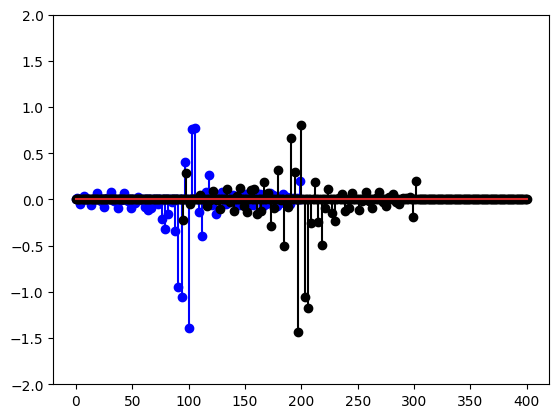

In [16]:
h_ipsi = compute_filter_response_ipsi(g, r, tau_s, 1, 100)
h_cont = compute_filter_response_cont(g, r, tau_s, 1, 100)

center = (len(h_ipsi)-1) // 2
plt.stem(h_ipsi, 'b', use_line_collection=True)
plt.stem(h_cont, 'k', use_line_collection=True)
plt.ylim(-2, 2)
plt.show()

In [18]:
plt.plot(psi1, label='psi1')
plt.plot(psi2, label='psi2')
plt.plot(psi3, label='psi3')
plt.plot(psi4, label='psi4')
plt.plot(psi5, label='psi5')
plt.plot(psi6c1, label='psi6c1')
plt.plot(psi6c2, label='psi6c2')
plt.legend()

NameError: name 'psi1' is not defined

In [1]:
from sympy import symbols, cos, sqrt, init_printing, init_session

# define symbol
z, g, omega, tau_c, gamma = symbols('z g omega tau_c gamma')

# define Beta_I & Beta_II
beta_I = -g**2 + 2*g*cos(omega*tau_c) + (sqrt(g**2 - 2*g*cos(omega*tau_c) + 1) / gamma) - 1
beta_II = -g**2 - 2*g*cos(omega*tau_c) + (sqrt(g**2 + 2*g*cos(omega*tau_c) + 1) / gamma) - 1

# define H_LL & H_LR representation
def compute_H_LL(beta):
    return (z**2 * g**2 - z * (beta + 1)) / (z**2 * g**2 + g**2 - z * ((g**2 + beta)**2 + 2 * beta + 1))

def compute_H_LR(beta):
    return (z * (g * z**(-1/2) - g * (g**2 + beta) * z**(1/2))) / (z**2 * g**2 + g**2 - z * ((g**2 + beta)**2 + 2 * beta + 1))

# Substitute Beta_I & Beta_II
H_LL_I = compute_H_LL(beta_I).simplify()
H_LR_I = compute_H_LR(beta_I).simplify()
H_LL_II = compute_H_LL(beta_II).simplify()
H_LR_II = compute_H_LR(beta_II).simplify()

# H_LL_I, H_LR_I, H_LL_II, H_LR_II

In [2]:
from IPython.display import display, Latex
from sympy import *

# x = symbols('x')
# display(x)

display(H_LL_I)

# int_x = Integral(cos(x)*exp(x), x)
# result = "$${} = {}$$".format(latex(int_x), latex(int_x.doit()))
# display(Latex(result))

# derv_x = Derivative(cos(x)*exp(x), x)
# result = "$${} = {}$$".format(latex(derv_x), latex(derv_x.doit()))
# display(Latex(result))

gamma*z*(g**2*gamma*z - g*gamma*(-g + 2*cos(omega*tau_c)) - sqrt(g**2 - 2*g*cos(omega*tau_c) + 1))/(g**2*gamma**2*(z**2 + 1) - z*(-4*g**2*gamma**2*sin(omega*tau_c)**2 + 2*g**2*gamma**2 + g**2 + 4*g*gamma*sqrt(g**2 - 2*g*cos(omega*tau_c) + 1)*cos(omega*tau_c) - 2*g*cos(omega*tau_c) + 1))

In [22]:
import numpy as np

a = np.zeros(129)
b = np.zeros(129)
c = np.zeros(129)
d = np.zeros(129)

t = np.convolve(a, b, mode='full')
print(len(t))

t = np.convolve(t, c, mode='full')
print(len(t))

t = np.convolve(t, d, mode='full')
print(len(t))

257
385
513


In [23]:
4*129-3

513

In [25]:
import math

n =0.5
k = 1
math.comb(n, k)

TypeError: 'float' object cannot be interpreted as an integer